# Method1 SVD+Huffman

### Code

#### Import the EDF file
Installation: https://mne.tools/dev/install/mne_python.html

Function description: https://mne.tools/dev/generated/mne.io.read_raw_edf.html

In [2]:
import mne
file = "/Users/lubaiying/Desktop/big_ideas_lab/DBDP_Compression_Toolbox/Baiying/ECG.EDF"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from /Users/lubaiying/Desktop/big_ideas_lab/DBDP_Compression_Toolbox/Baiying/ECG.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
info

<Info | 7 non-empty values
 bads: []
 ch_names: ECG, Marker, HRV
 chs: 3 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2019-07-23 12:16:57 UTC
 nchan: 3
 projs: []
 sfreq: 1000.0 Hz
>

#### Convert the edf file into csv and reload the csv file

In [4]:
import numpy as np
header = ','.join(data.ch_names)
np.savetxt('ECG.csv', data.get_data().T, delimiter=',', header=header)

In [5]:
import pandas as pd
ecg = pd.read_csv('ECG.csv')

In [6]:
ecg

,# ECG,Marker,HRV
0,0.032767,0.0,0.0
1,0.032767,0.0,0.0
2,0.032767,0.0,0.0
3,0.032767,0.0,0.0
4,0.032767,0.0,0.0
...,...,...,...
3269995,0.002334,0.0,0.0
3269996,0.002037,0.0,0.0
3269997,0.001726,0.0,0.0
3269998,0.001404,0.0,0.0


#### Plot the signal to explore the data

In [7]:
sampling_freq = 1/1000
N = 3270000

In [8]:
index = np.linspace(0, 3269.999, 3270000)
index

array([0.000000e+00, 1.000000e-03, 2.000000e-03, ..., 3.269997e+03,
       3.269998e+03, 3.269999e+03])

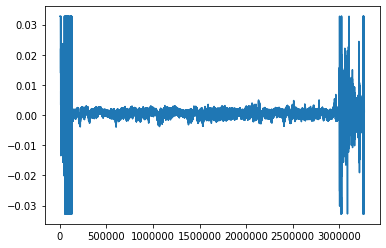

In [9]:
ecg["# ECG"].plot()

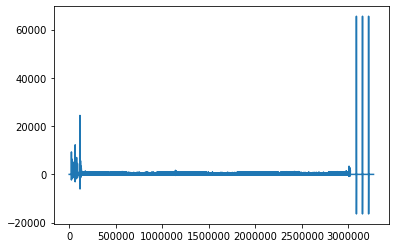

In [10]:
ecg["HRV"].plot()

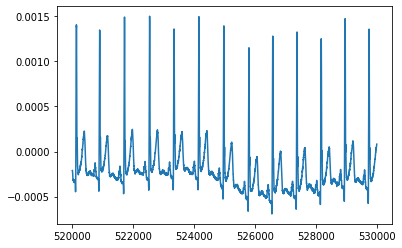

In [11]:
ECG_example = ecg["# ECG"][520000:530000]
ECG_example.plot()

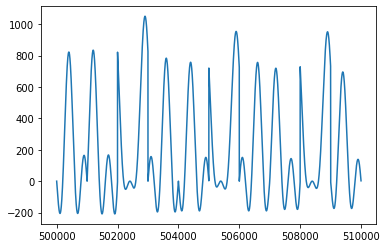

In [12]:
HRV_example = ecg["HRV"][500000:510000]
HRV_example.plot()

In [13]:
ECG_array = ecg["# ECG"].to_numpy()
ECG_array.size

3270000

In [15]:
xf = np.linspace(-1635, 1635, 3270000)
xf

array([-1635.   , -1634.999, -1634.998, ...,  1634.998,  1634.999,
        1635.   ])

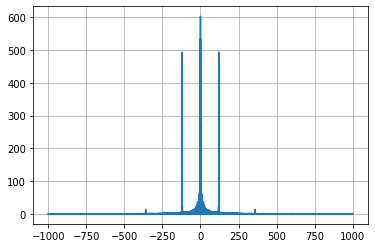

In [16]:
from scipy.fft import fft,fftshift
# Number of sample points

y = ECG_array
yf = fft(y)
yf = fftshift(yf)
xf = np.linspace(-1000, 1000, 3270000)
import matplotlib.pyplot as plt
plt.plot(xf, np.abs(yf))
#plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [ ]:
xf

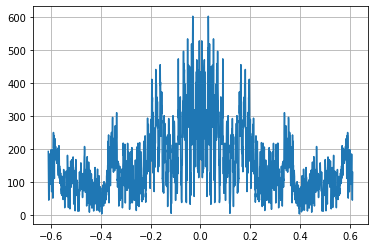

In [17]:
plt.plot(xf[1634000:1636000], np.abs(yf)[1634000:1636000])
#plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

#### Ideal filter

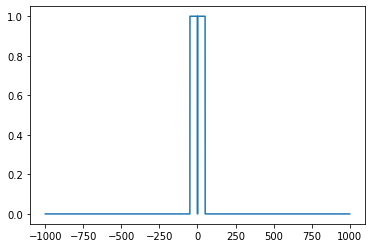

In [18]:
#Generate an ideal filter
ideal_filter = np.zeros(3270000)
ideal_filter[1553250:1634182] = 1
ideal_filter[1635818:1716750] = 1
plt.plot(xf,ideal_filter)

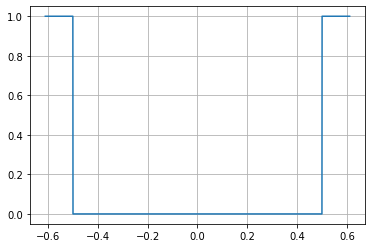

In [19]:
plt.plot(xf[1634000:1636000], np.abs(ideal_filter)[1634000:1636000])
#plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

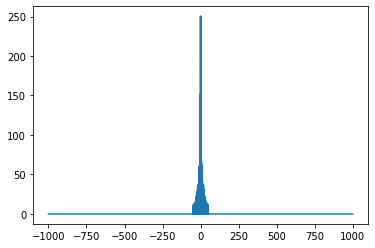

In [20]:
after_filter = ideal_filter*yf
plt.plot(xf,np.abs(after_filter))

//anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


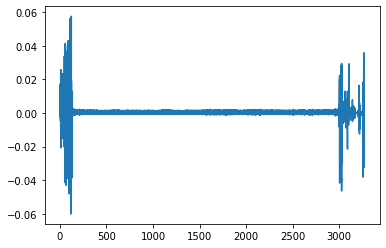

In [21]:
from scipy.fft import ifft,ifftshift
recover_ecg = ifftshift(after_filter)
recover_ecg = ifft(recover_ecg)
plt.plot(index, recover_ecg)

//anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


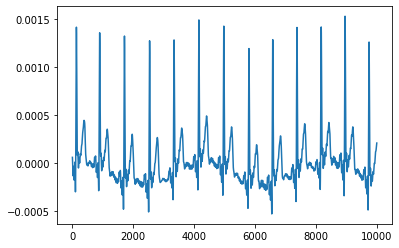

In [22]:
recover_ECG_example = recover_ecg[520000:530000]
plt.plot(recover_ECG_example)

The result shows that the ideal filter will introduce some baseline drift, so we plan to use butterworth filter later

#### Butterworth Band pass Filter

In [23]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

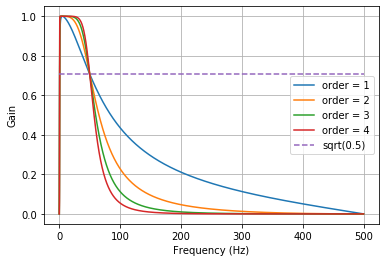

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1000.0
lowcut = 0.5
highcut = 50.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [1, 2, 3, 4]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

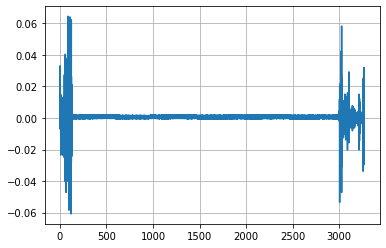

In [25]:
y = butter_bandpass_filter(ECG_array, lowcut, highcut, fs, order=2)
plt.plot(index, y, label='Filtered signal (Hz)')
#plt.xlabel('time (seconds)')
#plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
#plt.axis('tight')
#plt.legend(loc='upper left')
plt.show()

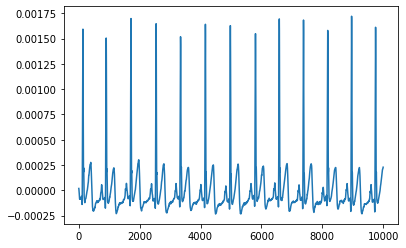

In [26]:
recover_ECG_example = y[520000:530000]
plt.plot(recover_ECG_example)

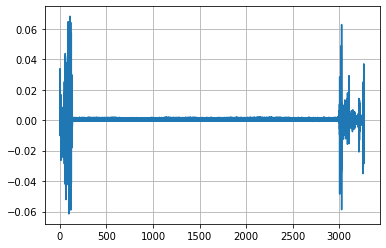

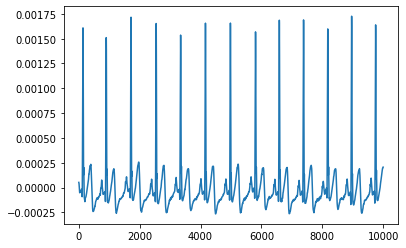

In [27]:
y = butter_bandpass_filter(ECG_array, lowcut, highcut, fs, order=3)
plt.plot(index, y, label='Filtered signal (Hz)')
#plt.xlabel('time (seconds)')
#plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
#plt.axis('tight')
#plt.legend(loc='upper left')
plt.show()
recover_ECG_example = y[520000:530000]
plt.plot(recover_ECG_example)
plt.show()

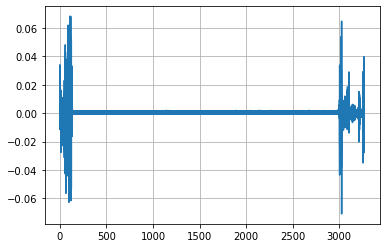

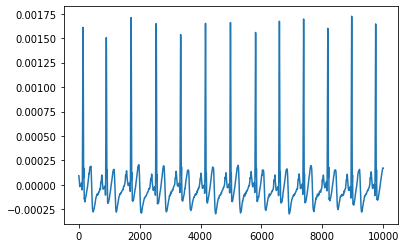

In [28]:
y = butter_bandpass_filter(ECG_array, lowcut, highcut, fs, order=4)
plt.plot(index, y, label='Filtered signal (Hz)')
#plt.xlabel('time (seconds)')
#plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
#plt.axis('tight')
#plt.legend(loc='upper left')
plt.show()
recover_ECG_example = y[520000:530000]
plt.plot(recover_ECG_example)
plt.show()

From the original signal, we could see that the T wave is much higher than P wave. Butterworth filter with order=2 could show that sucessfully. However, with order=3 and order=4, the difference between T wave and P wave are decreased.

#### Resampling
From 1000Hz to 200Hz, means resampling a signal from 3270000 points to 654000 points

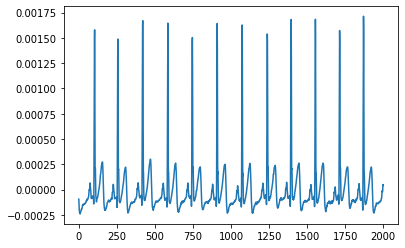

In [36]:
from scipy import signal
y = butter_bandpass_filter(ECG_array, lowcut, highcut, fs, order=2)
resampled_signal = signal.resample(y, 654481)
plt.plot(resampled_signal[104000:106000])
plt.show()

#### Amplitude Normalization

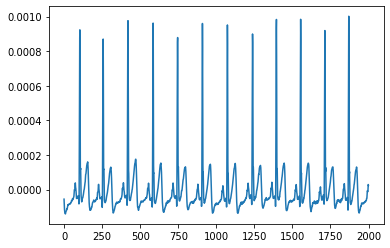

In [37]:
import numpy as np
from sklearn.preprocessing import normalize

normalized_signal = resampled_signal/np.linalg.norm(resampled_signal)
#norm1 = x / np.linalg.norm(x)
#norm2 = normalize(x[:,np.newaxis], axis=0).ravel()
plt.plot(normalized_signal[104000:106000])
plt.show()

#### SVD

In [44]:
from scipy import linalg
reshaped_signal = np.reshape(normalized_signal, (809,809))
U, s, Vh = linalg.svd(reshaped_signal)
print(reshaped_signal.shape)
print(U.shape)
print(s.shape)
print(Vh.shape)

(809, 809)
(809, 809)
(809,)
(809, 809)


#### Reconstruct the original matrix from the decomposition
For future decoding

In [49]:
m = 809
n = 809
sigma = np.zeros((m, n))
for i in range(min(m, n)):
    sigma[i, i] = s[i]
reconstructed_signal = np.dot(U, np.dot(sigma, Vh))
reshaped_recon_signal = np.reshape(reconstructed_signal, 654481)
np.allclose(reshaped_recon_signal, normalized_signal)
#True means the signal could be reconstructed back to the original one

True

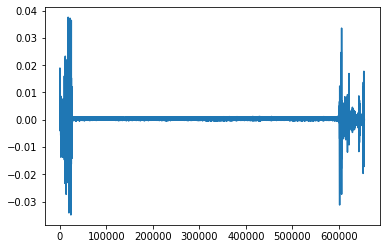

In [50]:
plt.plot(normalized_signal)

#### Quantization

In [57]:
print("The maximum of U is {}".format(np.max(U)))
print("The minimum of U is {}".format(np.min(U)))
print("The maximum of s is {}".format(np.max(s)))
print("The minimum of s is {}".format(np.min(s)))
print("The maximum of Vh is {}".format(np.max(Vh)))
print("The minimum of Vh is {}".format(np.min(Vh)))


The maximum of U is 0.8207743405630934
The minimum of U is -0.8098173685660472
The maximum of s is 0.3319800421063483
The minimum of s is 9.821479717252607e-08
The maximum of Vh is 0.28607844335201876
The minimum of Vh is -0.18537219952968262


In [61]:
np.min(np.abs(Vh))

6.291771919176431e-08

### Instructions

Put instructions of how to use your method here.

Dependencies:

### Evaluation

The results of this method on the following wearable sensors:

| Wearable Sensor | Compression Ratio | Percentage RMS difference |
| ------ | ------ | ------ | 
| ECG | XX | XX |
| PPG | XX | XX |
| ACC | XX | XX |
| EDA | XX | XX |
| TEMP | XX | XX |